In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-7b60eca3c4ed>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Create the data

In [3]:
nImages = 3000
imgSize = 64

x   = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)


# initialize tensors containing images and labels
images = torch.zeros(nImages,1,imgSize,imgSize)

for i in range(nImages):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  width = np.random.rand()/.6 + 1.8 # random width
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*width**2) )

  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

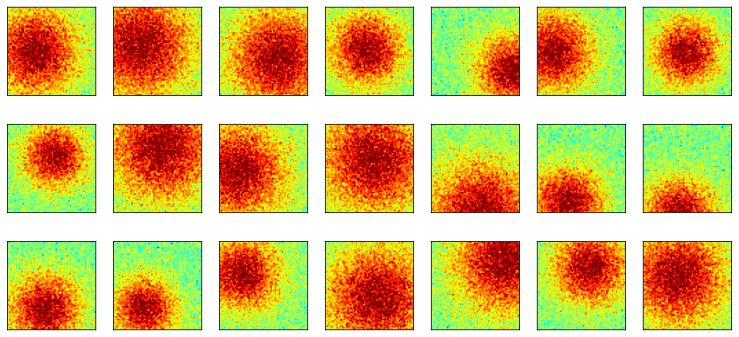

In [4]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nImages)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Create classes for the discriminator and generator

In [5]:
# Architecture and meta-parameter choices were inspired by https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

The code snippet outlines the definition of a `discriminatorNet` class using PyTorch, designed as a component of a Generative Adversarial Network (GAN). This discriminator network uses convolutional layers to process input images and distinguish between real and generated images. The network architecture is simplified and includes batch normalization to stabilize training. Here’s a breakdown of its key components and functionality:

### Network Architecture
- **Convolutional Layers**: The network consists of three convolutional layers. The first two layers (`self.conv1`, `self.conv2`) aim to extract features from the input images, progressively increasing the depth while reducing the spatial dimensions. The third convolutional layer (`self.conv3`) reduces the feature map to a single value, aiming to classify the input image as real or fake.
  - The kernel size for all convolutional layers is set to 4, and the stride to 3, with no padding (`0`). This configuration helps in reducing the dimensionality of the input image to a single classification output.
  - Bias is disabled (`bias=False`) for these layers, a choice often made to reduce the number of parameters when batch normalization is applied afterward.
- **Batch Normalization**: Applied after the second convolutional layer (`self.bn2`), batch normalization helps in stabilizing the learning by normalizing the output of the layer across the batch. This can lead to faster convergence and overall improved training performance.

### Forward Pass
- The `forward` method defines the path of the input data through the network. It applies leaky ReLU activation (`F.leaky_relu`) with a negative slope of `0.2` after each convolutional layer to introduce non-linearity. After the second convolutional layer, batch normalization is applied.
- The output of the final convolutional layer is passed through a sigmoid function (`torch.sigmoid`) to obtain a probability between `0` and `1`, indicating the network's confidence that the input image is real. This output is reshaped to a 2D tensor with dimensions `[-1, 1]` to match the expected format for binary classification.

### Network Instantiation and Testing
- An instance of `discriminatorNet` (`dnet`) is created, and a batch of 10 synthetic images of size `64x64` is passed through the network. The output shape (`y.shape`) is examined to ensure that the network produces the expected single-dimensional output per image, indicating the classification decision for each image as real or fake.

This discriminator network architecture is structured to effectively participate in the adversarial training process within a GAN, learning to distinguish real images from those generated by the counterpart generator network.


In [6]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.Conv2d(  1, 64, 4, 3, 0, bias=False)
    self.conv2 = nn.Conv2d( 64,128, 4, 3, 0, bias=False)
    self.conv3 = nn.Conv2d(128,  1, 4, 3, 0, bias=False)
    # self.conv4 = nn.Conv2d(256,512, 4, 2, 1, bias=False)
    # self.conv5 = nn.Conv2d(512,  1, 4, 1, 0, bias=False)

    # batchnorm
    self.bn2 = nn.BatchNorm2d(128)
    # self.bn3 = nn.BatchNorm2d(256)
    # self.bn4 = nn.BatchNorm2d(512)

  def forward(self,x):
    x = F.leaky_relu( self.conv1(x) ,.2)
    x = F.leaky_relu( self.conv2(x) ,.2)
    x = self.bn2(x)
    # x = F.leaky_relu( self.conv3(x) ,.2)
    # x = self.bn3(x)
    # x = F.leaky_relu( self.conv4(x) ,.2)
    # x = self.bn4(x)
    return torch.sigmoid( self.conv3(x) ).view(-1,1)


dnet = discriminatorNet()
y = dnet(torch.randn(10,1,64,64))
y.shape

torch.Size([10, 1])

torch.Size([10, 1, 64, 64])


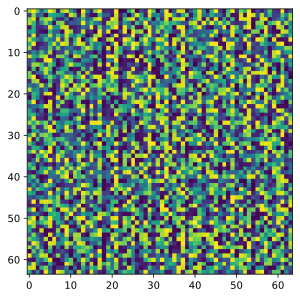

In [7]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.ConvTranspose2d(100,256, 4, 4, 0, bias=False)
    self.conv2 = nn.ConvTranspose2d(256,128, 4, 4, 0, bias=False)
    self.conv3 = nn.ConvTranspose2d(128,  1, 4, 4, 0, bias=False)
    # self.conv4 = nn.ConvTranspose2d( 64,  1, 4, 2, 0, bias=False)
    # self.conv5 = nn.ConvTranspose2d(64,   1, 4, 2, 1, bias=False)

    # batchnorm
    self.bn1 = nn.BatchNorm2d(256)
    self.bn2 = nn.BatchNorm2d(128)
    # self.bn3 = nn.BatchNorm2d( 64)
    # self.bn4 = nn.BatchNorm2d( 64)


  def forward(self,x):
    x = F.relu( self.bn1(self.conv1(x)) )
    x = F.relu( self.bn2(self.conv2(x)) )
    # x = F.relu( self.bn3(self.conv3(x)) )
    # x = F.relu( self.bn4(self.conv4(x)) )
    x = torch.tanh( self.conv3(x) )
    return x


gnet = generatorNet()
y = gnet(torch.randn(10,100,1,1))
print(y.shape)
plt.imshow(y[0,:,:,:].squeeze().detach().numpy());

# Train the models!

In [8]:
lossfun = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5,.999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5,.999))

In [10]:
# training parameters and initializations
num_epochs = 10500
batchsize  = 86
losses     = []
disDecs    = [] # disDecs = discriminator decisions


for epochi in range(num_epochs):

  # create a minibatch from randomly selected images
  ridx = torch.randint(images.shape[0],(batchsize,))
  data = images[ridx,:].to(device)


  # create labels for real and fake images
  real_labels = torch.ones(batchsize,1).to(device)
  fake_labels = torch.zeros(batchsize,1).to(device)



  ### ---------------- Train the discriminator ---------------- ###

  # forward pass and loss for REAL pictures
  pred_real   = dnet(data)                     # output of discriminator
  d_loss_real = lossfun(pred_real,real_labels) # all labels are 1

  # forward pass and loss for FAKE pictures
  fake_data   = torch.randn(batchsize,100,1,1).to(device) # random numbers to seed the generator
  fake_images = gnet(fake_data)                           # output of generator
  pred_fake   = dnet(fake_images)                         # pass through discriminator
  d_loss_fake = lossfun(pred_fake,fake_labels)            # all labels are 0

  # collect loss (using combined losses)
  d_loss = d_loss_real + d_loss_fake

  # backprop
  d_optimizer.zero_grad()
  d_loss.backward()
  d_optimizer.step()



  ### ---------------- Train the generator ---------------- ###

  # create fake images and compute loss
  fake_images = gnet( torch.randn(batchsize,100,1,1).to(device) )
  pred_fake   = dnet(fake_images)

  # compute loss
  g_loss = lossfun(pred_fake,real_labels)

  # backprop
  g_optimizer.zero_grad()
  g_loss.backward()
  g_optimizer.step()


  # collect losses and discriminator decisions
  losses.append([d_loss.item(),g_loss.item()])

  d1 = torch.mean((pred_real>.5).float()).detach()
  d2 = torch.mean((pred_fake>.5).float()).detach()
  disDecs.append([d1,d2])


  # print out a status message
  if (epochi+1)%50==0:
    msg = f'Finished epoch {epochi+1}/{num_epochs}'
    sys.stdout.write('\r' + msg)


# convert performance from list to numpy array
losses  = np.array(losses)

Finished epoch 10500/10500

In [12]:
import numpy as np

# Convert CUDA tensors to CPU tensors before converting to NumPy arrays
disDecs_cpu = [[t.cpu().numpy() for t in item] for item in disDecs]
# Convert to NumPy array
disDecs_np = np.array(disDecs_cpu)

In [13]:
# create a 1D smoothing filter
def smooth(x,k=15):
  return np.convolve(x,np.ones(k)/k,mode='same')

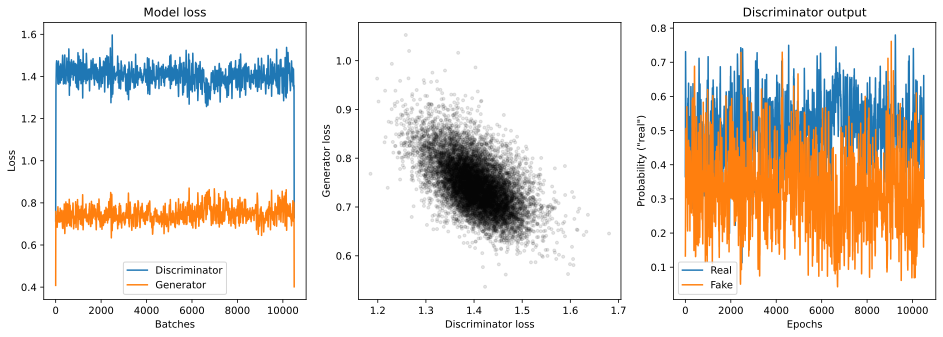

In [16]:
import matplotlib.pyplot as plt

# Convert CUDA tensors to CPU tensors before converting to NumPy arrays
disDecs_cpu = [[d1.cpu().numpy(), d2.cpu().numpy()] for d1, d2 in disDecs]
# Convert to NumPy array
disDecs_np = np.array(disDecs_cpu)

fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discriminator', 'Generator'])

ax[1].plot(losses[:,0], losses[:,1], 'k.', alpha=0.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

# Now use disDecs_np for indexing
ax[2].plot(smooth(disDecs_np[:,0]))
ax[2].plot(smooth(disDecs_np[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probability ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real', 'Fake'])

plt.show()

# Let's see some generated Gaussians!

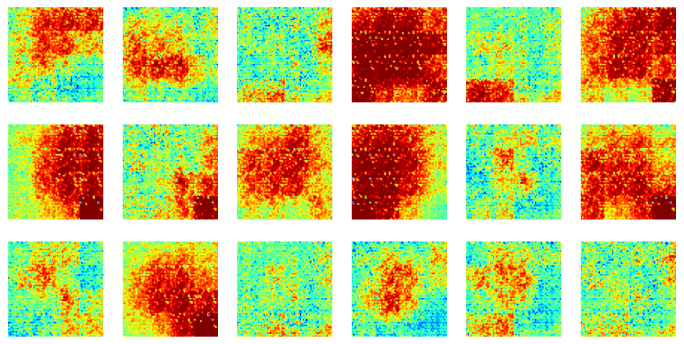

In [17]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batchsize,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,].detach().squeeze(),cmap='jet')
  ax.axis('off')

plt.show()